# Testing Sampling Validity

In [1]:
import torch
from data import sample_latents

n = 100000
k = 3
l = 2
delta = 0.2

z = sample_latents(n, k, l, 'random')
z_id = sample_latents(n, k, l, 'diagonal', delta=delta)
z_ood = sample_latents(n, k, l, 'off_diagonal', delta=delta)

def test_domain(z): return torch.logical_and(z >= 0, z <= 1).all()
def mutual_distances(z):
    triu_idcs = torch.triu_indices(k, k, 1)
    z = z.transpose(1, 2)
    triu_idcs = torch.triu_indices(k, k, 1)
    return (z.unsqueeze(2) - z.unsqueeze(2).transpose(2, 3))[:, :, triu_idcs[0], triu_idcs[1]]
def id_mask(z): return (mutual_distances(z).abs() <= 2*delta).all(dim=2).all(dim=1)
def ood_mask(z): return (mutual_distances(z).abs() > 2*delta).any(dim=2).any(dim=1)

print('RANDOM')
print(f'in domain: {test_domain(z)}')
print(f'ID ∪ OOD = all: {torch.logical_or(id_mask(z), ood_mask(z)).all()}')
print(f'ID ∩ OOD = none: {~torch.logical_and(id_mask(z), ood_mask(z)).any()}')

print('\nID')
print(f'in domain: {test_domain(z_id)}')
print(f'all ID: {id_mask(z_id).all()}')
print(f'none OOD: {~ood_mask(z_id).any()}')

print('\nOOD')
print(f'in domain: {test_domain(z_ood)}')
print(f'none ID: {~id_mask(z_ood).any()}')
print(f'all OOD: {ood_mask(z_ood).all()}')

RANDOM
in domain: True
ID ∪ OOD = all: True
ID ∩ OOD = none: True

ID
in domain: True
all ID: True
none OOD: True

OOD
in domain: True
none ID: True
all OOD: True


# Continuous Subspace

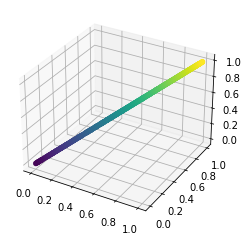

In [16]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as nnf

n = 1000
k = 3
l = 1

z = torch.repeat_interleave(torch.rand(n, l), k, dim=0).reshape(n, k, l)

# class Scale(nn.Module):
#     def __init__(self, factor):
#         super(Scale, self).__init__()
#         self.factor = factor
    
#     def forward(self, x):
#         return x * self.factor



color = z.flatten(1).numpy()[:, 0]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(z.flatten(1)[:, 0], z.flatten(1)[:, 1], z.flatten(1)[:, 2], c=color)
plt.show()
# plt.scatter(z_def.flatten(1).numpy()[:, 0], z_def.flatten(1).numpy()[:, 1], c=color)

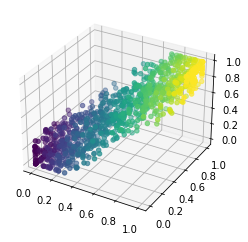

In [25]:
import matplotlib.pyplot as plt
import torch

n = 1000
k = 3
l = 1
delta = 0.2

z = torch.repeat_interleave(torch.rand(n, l), k, dim=0).reshape(n, k, l)
d = torch.rand(n, k, l) * 2 * delta - delta
z += d
z = z.clamp(0, 1)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
color = z.flatten(1).numpy()[:, 0]
ax.scatter(z.flatten(1)[:, 0], z.flatten(1)[:, 1], z.flatten(1)[:, 2], c=color)
plt.show()

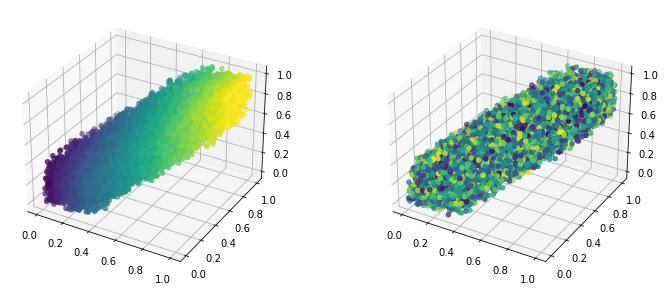

In [19]:
import matplotlib.pyplot as plt
import torch

n = 10000
k = 3
l = 2
delta = 0.2

_n = 10*n
z = torch.Tensor(0, k, l)
while z.shape[0] < n:
    # sample randomly on diagonal
    _z = torch.repeat_interleave(torch.rand(n, l), k, dim=0).reshape(n, k, l)
    # apply random offset
    _z += torch.rand(n, k, l) * 2 * delta - delta
    # reject samples outside the domain
    mask = ~((_z - 0.5).abs() > 0.5).flatten(1).any(1)
    # mask = ~torch.logical_or(z > 1, z < 0).flatten(1).any(1)
    idx = mask.nonzero().squeeze(1)
    z = torch.cat([z, _z[idx]])
z = z[:n]

fig = plt.figure(figsize=(l*6, 5))
color = z.numpy()[:, 0, 0]
for _l in range(l):
    if k==2:
        ax = fig.add_subplot(1, l, _l+1)
        ax.scatter(z[:, 0, _l], z[:, 1, _l], c=color)
    elif k==3:
        ax = fig.add_subplot(1, l, _l+1, projection='3d')
        ax.scatter(z[:, 0, _l], z[:, 1, _l], z[:, 2, _l], c=color)
plt.show()

torch.Size([4199511]) torch.Size([0, 3, 2]) torch.Size([4199511, 3, 2])


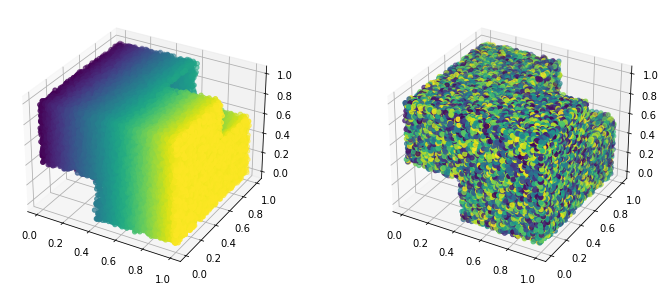

In [5]:
import matplotlib.pyplot as plt
import torch

n = 100000
k = 3
l = 2
delta = 0.2

_n = 100 * n
z = torch.Tensor(0, k, l)
while z.shape[0] < n:
    _z = torch.rand(_n, k, l)
    triuidx = torch.triu_indices(k, k)
    mutual_distances = (_z.unsqueeze(1).repeat(1, _z.shape[1], 1, 1) - _z.unsqueeze(1).repeat(1, _z.shape[1], 1, 1).transpose(1, 2))[:, triuidx[0], triuidx[1], :]
    mask = (mutual_distances.abs() > 2*delta).any(dim=1).all(dim=1)
    # mask = (mutual_distances.abs() <= 2*delta).all(dim=1).all(dim=1)
    idx = mask.nonzero().squeeze()
    print(idx.shape, z.shape, _z[idx].shape)
    z = torch.cat([z, _z[idx]])
z = z[:n]

fig = plt.figure(figsize=(l*6, 5))
color = z.numpy()[:, 0, 0]
for _l in range(l):
    if k==2:
        ax = fig.add_subplot(1, l, _l+1)
        ax.scatter(z[:, 0, _l], z[:, 1, _l], c=color)
    elif k==3:
        ax = fig.add_subplot(1, l, _l+1, projection='3d')
        ax.scatter(z[:, 0, _l], z[:, 1, _l], z[:, 2, _l], c=color)
plt.show()

torch.Size([999939]) torch.Size([0, 3, 2]) torch.Size([999939, 3, 2])


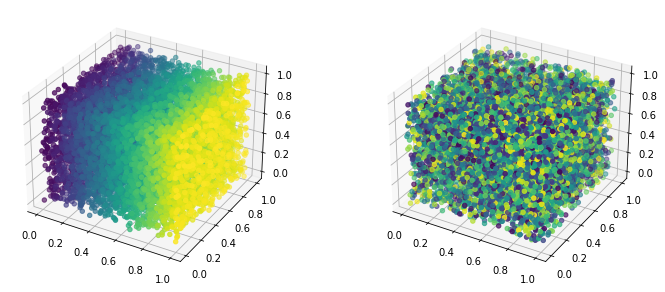

In [4]:
import matplotlib.pyplot as plt
import torch

n = 10000
k = 3
l = 2
delta = 0.2

_n = 100 * n
z = torch.Tensor(0, k, l)
while z.shape[0] < n:
    _z = torch.rand(_n, k, l)
    # triuidx = torch.triu_indices(k, k)
    # mutual_distances = (_z.unsqueeze(1).repeat(1, _z.shape[1], 1, 1) - _z.unsqueeze(1).repeat(1, _z.shape[1], 1, 1).transpose(1, 2))[:, triuidx[0], triuidx[1], :]
    # mask = (mutual_distances.abs() > 2*delta).any(dim=1).any(dim=1)
    # __z = _z.reshape(-1, _z.shape[1])
    triu_idcs = torch.triu_indices(k, k, 1)
    __z = _z.transpose(1, 2)
    triu_idcs = torch.triu_indices(k, k, 1)
    mutual_distances = (__z.unsqueeze(2) - __z.unsqueeze(2).transpose(2, 3))[:, :, triu_idcs[0], triu_idcs[1]]
    mask = (mutual_distances.abs() <= 2*delta).any(dim=2).any(dim=1)
    idx = mask.nonzero().squeeze(1)
    print(idx.shape, z.shape, _z[idx].shape)
    z = torch.cat([z, _z[idx]])
z = z[:n]

fig = plt.figure(figsize=(l*6, 5))
color = z.numpy()[:, 0, 0]
for _l in range(l):
    if k==2:
        ax = fig.add_subplot(1, l, _l+1)
        ax.scatter(z[:, 0, _l], z[:, 1, _l], c=color)
    elif k==3:
        ax = fig.add_subplot(1, l, _l+1, projection='3d')
        ax.scatter(z[:, 0, _l], z[:, 1, _l], z[:, 2, _l], c=color)
plt.show()

In [11]:
z = torch.rand(_n, k, l)
idx = (torch.abs(z[:, 1:, :] - z[:, 0, :].unsqueeze(1)) > 2*delta).any(dim=1).all(dim=1).nonzero().squeeze()

In [26]:
triuidx = torch.triu_indices(k, k)
((z.unsqueeze(1).repeat(1, z.shape[1], 1, 1) - z.unsqueeze(1).repeat(1, z.shape[1], 1, 1).transpose(1, 2))[:, triuidx[0], triuidx[1], :] > 0.2).any(dim=1).all(dim=1).nonzero().squeeze().shape

torch.Size([38304])

torch.Size([1000, 3, 1])
torch.Size([1000, 3, 1])


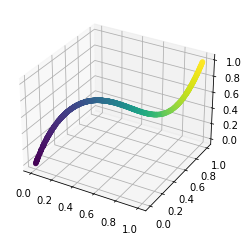

In [6]:
class NormalizeDims(nn.Module):
    def __init__(self, k, l):
        super(NormalizeDims, self).__init__()
        self.k, self.l = k, l
    
    def forward(self, x):
        z = x.reshape(-1, self.k * self.l)
        lims = []
        for i in range(self.k * self.l):
            # lims.append({'min': x[:,i].min(), 'max': x[:,i].max()})
            _min = z[:, i].min()
            _max = z[:, i].max()
            z[:, i] = (z[:, i] - _min) / (_max-_min)

        return z.flatten()

D = 100
deform = nn.Sequential(
        nn.Linear(k * l, D),
        nn.Tanh(),
        nn.Linear(D, k * l),
        nn.Tanh(),
        NormalizeDims(k, l)
    )

with torch.no_grad():
    z_def = deform(z.flatten(1)).reshape(n, k, l)
    t = -pow((2 * (z[:, 0] - 0.5)), 2) + 1
    t = t.unsqueeze(1).repeat(1, 3, 1)
    print(t.shape)
    print(z_def.shape)
    z_def = t * z_def + (1 - t) * z

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(z.flatten(1).numpy()[:, 0], z_def.flatten(1).numpy()[:, 1], z_def.flatten(1).numpy()[:, 2], c=color)
plt.show()

1
2


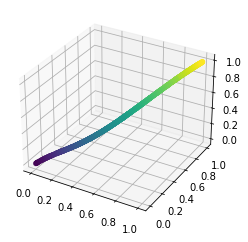

In [4]:
class Deform(nn.Module):
    def __init__(self, k, l, D=100):
        super().__init__()
        self.k, self.l = k, l
        self.deform = nn.Sequential(
            nn.Linear(1, D),
            nn.Tanh(),
            nn.Linear(D, 1),
        )
    
    def forward(self, x):
        xx = x.reshape(-1, self.k * self.l).clone()
        lims = []
        for i in range(1, self.k * self.l):
            print(i)
            xxx = self.deform(xx[:, i].unsqueeze(1)).squeeze()
            _min = xxx.min()
            _max = xxx.max()
            xxx = (xxx - _min) / (_max-_min)
            t = -pow((2 * (xx[:, 0] - 0.5)), 2) + 1
            xx[:, i] = t * xxx + (1 - t) * xx[:, i]

        return xx.flatten()

with torch.no_grad():
    z_def = Deform(k, l)(z.flatten(1)).reshape(n, k, l)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(z_def.flatten(1).numpy()[:, 0], z_def.flatten(1).numpy()[:, 1], z_def.flatten(1)[:, 2], c=color)
plt.show()

tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[1.0000, 0.9985, 0.9951],
        [0.9985, 1.0000, 0.9986],
        [0.9951, 0.9986, 1.0000]])
tensor([[1.0000, 0.9621, 0.8699],
        [0.9621, 1.0000, 0.9637],
        [0.8699, 0.9637, 1.0000]])
tensor([[1.0000, 0.8380, 0.5317],
        [0.8380, 1.0000, 0.8364],
        [0.5317, 0.8364, 1.0000]])
tensor([[1.0000, 0.6400, 0.3147],
        [0.6400, 1.0000, 0.6416],
        [0.3147, 0.6416, 1.0000]])
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
tensor([[1.0000, 0.9946, 0.9785],
        [0.9946, 1.0000, 0.9946],
        [0.9785, 0.9946, 1.0000]])
tensor([[1.0000, 0.9233, 0.7394],
        [0.9233, 1.0000, 0.9201],
        [0.7394, 0.9201, 1.0000]])
tensor([[1.0000, 0.7369, 0.4226],
        [0.7369, 1.0000, 0.7308],
        [0.4226, 0.7308, 1.0000]])
tensor([[1.0000, 0.5577, 0.2658],
        [0.5577, 1.0000, 0.5668],
        [0.2658, 0.5668, 1.0000]])
tensor([[1., 1., 1.],
        [1., 1., 1.]

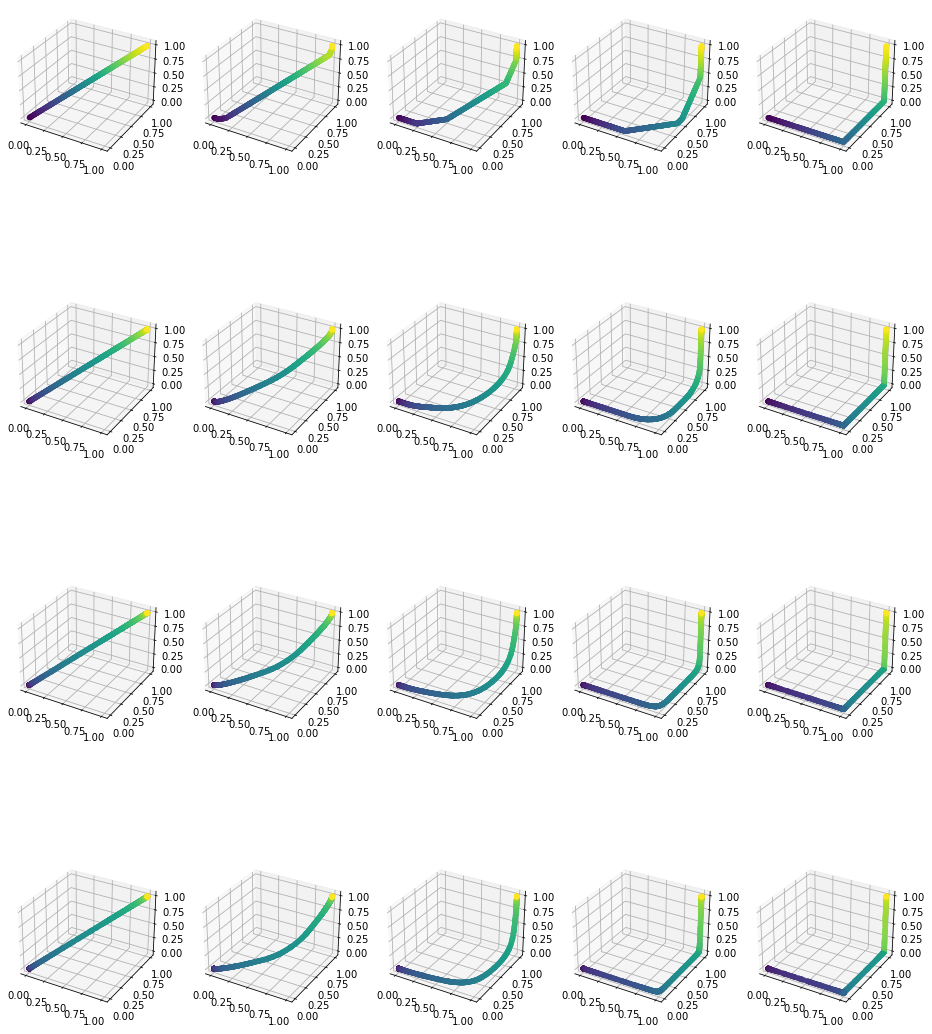

In [7]:
from numpy import linspace


class DeformSmooth(nn.Module):
    def __init__(self, order: int=4, a: float=0):
        super(DeformSmooth, self).__init__()
        assert order > 0, 'order must be an integer > 0'
        assert 0 <= a and a <= 1, 'a must be from [0, 1]'
        self.a = pow(a, 2)

        if order % 2:
            half_step = lambda x: torch.minimum(torch.maximum(torch.pow(2 * x, order), torch.zeros_like(x)), torch.ones_like(x)) / 2
        else:
            half_step = lambda x: torch.pow(torch.minimum(torch.maximum(2 * x, torch.zeros_like(x)), torch.ones_like(x)), order) / 2
        
        self.step = lambda x: half_step(x) - half_step(1 - x) + 0.5
    
    def forward(self, x):
        out = torch.zeros_like(x)
        n = x.shape[1]

        for d in range(n):
            out[:, d] = self.step(((n - 1) * self.a + 1) * x[:, d] - d * self.a)
        
        return out

fig = plt.figure(figsize=(16, 20))

for i, order in enumerate(range(1, 5)):
    for j, a in enumerate(linspace(0, 1, 5)):
        with torch.no_grad():
            z_def = DeformSmooth(order, a)(z.flatten(1))
        ax = fig.add_subplot(4, 5, i*5+j+1, projection='3d')
        ax.scatter(z_def[:, 0], z_def[:, 1], z_def[:, 2], c=color)
        pearson = torch.corrcoef(z_def.t())
        print(pearson)

plt.show()

# Non-Continuous Subspace

In [15]:
# import matplotlib.pyplot as plt
import math
import torch
import numpy as np
# import torch.nn as nn
# import torch.nn.functional as nnf
from scipy.signal import correlate2d

n = 1000
k = 3
l = 2


def corr2_coeff(A: torch.Tensor, B: torch.Tensor) -> float:
    """Returns the person-correlation coefficient between A and B for multidimensional observations.

    Each observation is treated as _a single d-dimensional variable_, _not a list of d one-dimenstional variables_.
    
    Parameters:
        A (torch.Tensor): n×d matrix, where n is the number of observations with dimensionality d
        B (torch.Tensor): n×d matrix, where n is the number of observations with dimensionality d
    
    Returns:
        (float): correlation coefficient
    """
    assert A.ndim == 2, 'inputs must be 2-dimensional arrays'
    assert A.ndim == 2, 'inputs must be 2-dimensional arrays'
    assert A.shape == B.shape, 'inputs must have the same shape'

    A_mA = A - A.mean(0).unsqueeze(0)
    B_mB = B - B.mean(0).unsqueeze(0)

    ssA = torch.tensordot(A_mA, A_mA.t(), dims=([1, 0], [0, 1])).sum()
    ssB = torch.tensordot(B_mB, B_mB.t(), dims=([1, 0], [0, 1])).sum()

    return torch.tensordot(A_mA, B_mB.t(), dims=([1, 0], [0, 1])) /  math.sqrt(ssA * ssB)


def corr2_matrix(A: torch.Tensor, B: torch.Tensor=None) -> torch.Tensor:
    """Returns the person-correlation matrix between A and B for multidimensional observations.

    Each observation is treated as _a list of v d-dimensional variables_.

    Parameters:
        A (torch.Tensor): n×v×d tensor with n oberservations of v d-dimensional variables
        B (torch.Tensor): n×v×d tensor with n oberservations of v d-dimensional variables
    
    Returns:
        (torch.Tensor): correlation coefficient matrix
    """
    if B is None: B = A
    assert A.ndim > 2, 'inputs must be at least 3-dimensional'
    assert A.ndim > 2, 'inputs must be at least 3-dimensional'
    assert A.shape == B.shape, 'inputs must have the same shape'

    # dim 0 are the obersvations, dim 1 are the variables, everything else are the variables
    A = A.flatten(2)
    B = B.flatten(2)

    out = torch.zeros([A.shape[1]]*2)
    for i in range(A.shape[1]):
        for j in range(B.shape[1]):
            out[i, j] = corr2_coeff(A[:,i,:], B[:,j,:])
    
    return out

z_diag = torch.repeat_interleave(torch.rand(n, l), k, dim=0).reshape(n, k, l)
print(f'Pearson correlation matrix\n{corr2_matrix(z_diag).numpy()}')

Pearson correlation matrix
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


In [12]:
z_rand = torch.rand(n, k, l)
print(f'Pearson correlation matrix\n{corr2_matrix(z_rand).numpy()}')

Pearson correlation matrix
[[ 1.         -0.05311733 -0.01569414]
 [-0.05311733  1.         -0.01611263]
 [-0.01569414 -0.01611263  1.        ]]


In [47]:
weight = 0
n_diag = int(n * weight,)
_z_diag = torch.repeat_interleave(torch.rand(n_diag, l), k, dim=0).reshape(n_diag, k, l)
_z_rand = torch.rand(n - n_diag, k, l)
z_mix = torch.cat([_z_diag, _z_rand])[torch.randperm(n)]
print(f'Pearson correlation matrix\n{corr2_matrix(z_mix).numpy()}')

Pearson correlation matrix
[[ 1.         -0.03051797  0.01343729]
 [-0.03051797  1.          0.02341016]
 [ 0.01343729  0.02341016  1.        ]]
